In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from classes import WikiArts

from torch.utils.data import DataLoader


In [2]:
path_labels = r'./output/path_label.csv'
path_images = r'./wikiart_500_paintings'

# Image pre-processing

### Transform images (normalization, resize, to tensor)

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
data = WikiArts(path_labels, path_images, transform)


### Split data

In [4]:
train_dataset, test_dataset = torch.utils.data.random_split(data, [len(data) - int(0.15*len(data)), int(0.15*len(data))])
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - int(0.15*len(data)), int(0.15*len(data))])

### Data loaders to load data in batches

In [5]:
num_workers = 2
batch_size = 25

In [6]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers)

In [7]:
# Save loader
torch.save(train_loader, './output/train_loader.pth')
torch.save(valid_loader, './output/valid_loader.pth')
torch.save(test_loader, './output/test_loader.pth')

# Import pre-trained model

In [7]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

Using cache found in /home/hub/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/hub/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/hub/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [8]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [9]:
# Replace the last fully connected layer by a new one with the number of artists we want to classify. In our example case, let us take 2

num_classes = 22 #TO CHANGE REGARDING THE NUMBER OF ARTISTS WE WANT
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)

# Train the model

In [10]:
device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)
resnet50 = resnet50.to(device)
device_string

'cpu'

In [10]:
num_epochs = 10
learning_rate = 0.001
mom = 0.9

#### Optimizer: SGD
#### Loss function: cross entropy

In [12]:
ct = 0
for child in resnet50.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [13]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, resnet50.parameters()), lr=learning_rate, momentum=mom)

In [14]:
BEST_MODEL_PATH = './output/best_model_optmiSGD_lossCrossEntrop_freezed_lr0.001.pth'
BEST_OPTIMIZER_PATH = './output/best_optim_optmiSGD_lossCrossEntrop_freezed_lr0.001.pth'
best_accuracy = 0.0
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0

    # Train set
    resnet50.train()
    # i = 0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(images)
        labels=torch.from_numpy(
            np.array([labels[i] for i in range (len(labels))])).long()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    # Valid set
    resnet50.eval()
    valid_error_count = 0.0
    for data, target in valid_loader:     
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        loss = F.cross_entropy(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        valid_error_count += float(len(labels[labels != outputs.argmax(1)]))

    # Comparison valid and test set for each epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Calculate accuracy for validation dataset
    validation_accuracy = 1.0 - float(valid_error_count) / float(len(valid_dataset))
    valid_accuracies.append(validation_accuracy)
    print('%d: %f' % (epoch, validation_accuracy))
    if validation_accuracy >= best_accuracy:
        torch.save(resnet50.state_dict(), BEST_MODEL_PATH)
        torch.save(optimizer.state_dict(), BEST_OPTIMIZER_PATH)
        best_accuracy = validation_accuracy

rembrandt_the-woman-with-the-arrow-1661.jpgclaude-monet_poppy-field-in-giverny-02.jpg

john-singer-sargent_nonchaloir-repose-1911.jpg
martiros-saryan_sunny-landscape-1923.jpg
pierre-auguste-renoir_landscape-1902.jpg
rembrandt_self-portrait-leaning-on-a-stone-sill-1639.jpg
nicholas-roerich_himalayas-15.jpg
camille-pissarro_pere-melon-resting-1879.jpg
pierre-auguste-renoir_farm-courtyard.jpg
ivan-aivazovsky_the-shipwreck-in-a-stormy-sea.jpg
rembrandt_portrait-of-cornelia-pronck-wife-of-albert-cuyper-at-the-age-of-33-1633.jpg
pierre-auguste-renoir_the-daughters-of-paul-durand-ruel-marie-theresa-and-jeanne-1882.jpg
john-singer-sargent_mrs-abbott-lawrence-rotch-1903.jpg
boris-kustodiev_english-wonders-buremetr-1926.jpg
nicholas-roerich_priest-from-gryzovo-1893.jpg
nicholas-roerich_karelian-study-1918.jpg
edgar-degas_a-visit-to-the-museum.jpg
claude-monet_waterloo-bridge-sunlight-effect-1.jpg
gustave-dore_the-temptation-of-jesus.jpg
vincent-van-gogh_woman-sitting-at-the-fireside-1881.jpg
pau

Corrupt JPEG data: bad Huffman code


nicholas-roerich_himalayas-34.jpg
martiros-saryan_portrait-of-a-film-director-ruben-simonov-1939.jpg
marc-chagall_lovers-near-bridge-1948.jpg
marc-chagall_vitebsk-1914.jpg
vincent-van-gogh_apartment-blocks-and-miscellaneous-studies(1).jpg
ilya-repin_duel-between-onegin-and-lenski-1899.jpg
gustave-dore_orlando-furioso-7.jpg
vincent-van-gogh_head-of-a-peasant-with-a-pipe-1885(1).jpg
john-singer-sargent_mrs-john-william-crombie-minna-watson.jpg
raphael-kirchner_portraits-of-viennese-ladies-1901-1.jpg
claude-monet_rowboat-on-the-seine-at-jeufosse.jpg
boris-kustodiev_sweets-still-life.jpg
vincent-van-gogh_head-of-a-peasant-woman-with-dark-cap-1885-4(1).jpg
john-singer-sargent_mrs-charles-f-st-clair-anstruther-thompson-nee-agnes-1898.jpg
boris-kustodiev_before-the-ball.jpg
eugene-boudin_pheasant-duck-and-fruit-1879.jpg
gustave-dore_and-seems-a-moving-land-and-at-his-gills-draws-in-and-at-his-trunk-spouts-out-a-sea.jpg
martiros-saryan_a-room-1935.jpg
paul-cezanne_still-life-with-seven-apples-

KeyboardInterrupt: 

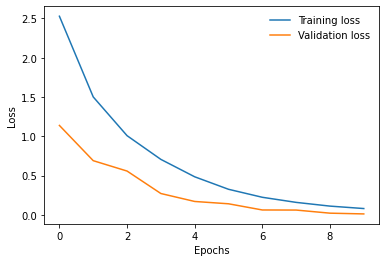

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

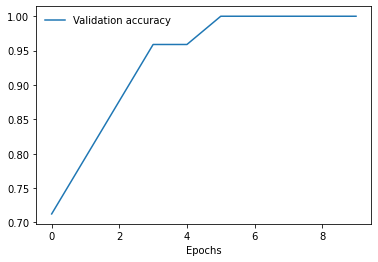

In [25]:
plt.plot(valid_accuracies, label='Validation accuracy')
plt.xlabel("Epochs")
plt.legend(frameon=False)

In [37]:
# Confirm results on test set - with last model
    # Test set
test_accuracies = []

resnet50.eval()
with torch.no_grad(): 
    test_error_count = 0.0
    for images, labels in iter(test_loader):
        outputs = resnet50(images)
        for x in outputs:
            probabilities = torch.nn.functional.softmax(x, dim=0)
        test_error_count += float(len(labels[labels != outputs.argmax(1)]))
    test_accuracy = 1.0 - float(test_error_count) / float(len(test_dataset))
    test_accuracies.append(test_accuracy)
    print('accuracy test set: %f' % (test_accuracy))


accuracy test set: 0.037227
